### PyTorch Datasets ###

In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import logging
import albumentations as alb
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# From the HuggingFace library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
from transformers import TrainingArguments, Trainer

# From the PyTorch library
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData, is_image, yolo2xywh, xywh2yolo, clipxywh
from computervision.transformations import DETRansform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

xrays_dir = os.path.join(data_dir, 'dentex', 'cropped')

# Load the annotations with data splits
parquet_file_name = 'train_quadrant_enumeration_dset.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')

data_dir: /app/data


In [3]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

In [4]:
# Let's validate the image data before we do anything else
for file_name in df['file_name'].unique():
    bad_files = []
    if not is_image(os.path.join(xrays_dir, file_name)):
        bad_files.append(file_name)
if len(bad_files) == 0:
    print('All files are good!')
else:
    print(f'Could not open these files: \n {bad_files}')

All files are good!


In [5]:
display(df.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4,train


Found 4 images for base image train_109


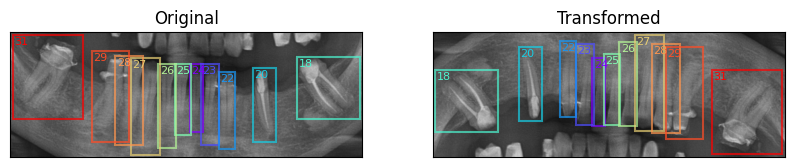

In [6]:
# Load an image and verify the model input processing
px_idx = 12
file_base_name = df['file_base_name'].unique()[px_idx]

# Get the cropped images and pick one
file_name_list = df.loc[df['file_base_name'] == file_base_name, 'file_name'].unique()
print(f'Found {len(file_name_list)} images for base image {file_base_name}')
crop_idx = 1
file_name = file_name_list[crop_idx]

# Let's get the index of the image in the list of all files
file_name_idx = list(df['file_name'].unique()).index(file_name)

# Load the image and bounding boxes for this file
df_file = df.loc[df['file_name'] == file_name]
file = os.path.join(xrays_dir, file_name)

# Load the image
im = ImageData().load_image(file)

# Convert to RGB
im = ImageData().np2color(im)

# Bounding boxes and labels
bboxes = df_file['bbox'].tolist()
labels = df_file['ada'].tolist()

# Image transformation
bbox_format = {'format': 'coco',
               'label_fields': ['tooth_position'],
               'clip': True}

transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]

# Transform the image and annotations
detr = DETRansform(bbox_format=bbox_format, transformations=transformations)
transformed_im, transformed_annotations = detr.\
    format_transform(image=im, image_id=crop_idx, bboxes=bboxes, labels=labels)

# Annotations after the transform
transformed_bboxes = [annotation['bbox'] for annotation in transformed_annotations['annotations']]
transformed_labels = [annotation['category_id'] for annotation in transformed_annotations['annotations']]

# Show the image with the bounding boxes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0] = plot_boxes(image=im, box_list=bboxes, ax=ax[0], label_list=labels)
ax[0].set(title='Original')
ax[1] = plot_boxes(image=transformed_im, box_list=transformed_bboxes, label_list=transformed_labels, ax=ax[1])
ax[1].set(title='Transformed')
plt.show()

In [7]:
# Image processing for the model input
model_checkpoint = 'PekingU/rtdetr_v2_r101vd'

im_size = 640

# We want to maintain the aspect ratio of the images
# So, we resize the image first and then pad it
processor_params = {'do_resize': True,
                    'size': {'max_height': im_size,
                             'max_width': im_size},
                    'do_pad': True,
                    'pad_size': {'height': im_size,
                                 'width': im_size}}
                    
image_processor = RTDetrImageProcessor.from_pretrained(model_checkpoint, **processor_params)

# Let's take a look at the image_processor parameters using the model checkpoint
display(image_processor)

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

RTDetrImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": false,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 640,
    "width": 640
  },
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "max_height": 640,
    "max_width": 640
  }
}

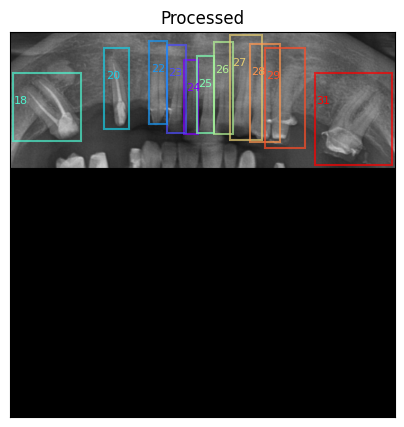

In [8]:
# Process the image and annotations
output = image_processor(images=transformed_im, 
                         annotations=transformed_annotations, 
                         return_tensors='pt')

# The "pixel_value" field contains a list of images
proc_image_tensor = output.get('pixel_values')[0]
proc_image = np.transpose(proc_image_tensor.numpy(), (1, 2, 0))

# The "labels" field contains a list of annotations
proc_annotation = output.get('labels')[0]

# The output bounding boxes are in yolo format (x_center, y_center, width, height)
# The input size depends on the pre-training
proc_size = list(proc_annotation.get('size').numpy().astype(int))
proc_width, proc_height = int(proc_size[1]), int(proc_size[0])
proc_labels = list(proc_annotation.get('class_labels').numpy())
proc_boxes_yolo = list(proc_annotation.get('boxes').numpy())

# We need to convert the bounding boxes from yolo format into the coco format
proc_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                             image_width=proc_width, 
                             image_height=proc_height) for yolobox in proc_boxes_yolo] 

# Let's also clip the new bounding boxes to the image boundaries
proc_boxes_xywh = [clipxywh(box, xlim=[0, proc_width], ylim=[0, proc_height], decimals=0) for box in proc_boxes_xywh]

# Show the output of the processed image and annotations
fig, ax = plt.subplots(figsize=(5, 5))
ax = plot_boxes(image=proc_image, box_list=proc_boxes_xywh, ax=ax, label_list=proc_labels)
ax.set(title='Processed')
plt.show()

In [9]:
print(proc_image.shape)
print(proc_size)

(640, 640, 3)
[640, 640]


### PyTorch Dataset Class ###

In [10]:
class DatasetFromDF(Dataset):
    def __init__(self,
                 data: pd.DataFrame,
                 image_processor,
                 image_dir: str,
                 file_name_col: str,
                 label_id_col: str,
                 bbox_col: str,
                 transformations: list = None):
        
        self.data = data
        self.image_processor = image_processor
        self.image_dir = image_dir
        self.file_name_col = file_name_col
        self.label_id_col = label_id_col
        self.bbox_col = bbox_col
        self.transformations = transformations
        if transformations is None:
            self.transformations = [alb.NoOp()]
        self.file_list = [os.path.join(image_dir, file) for file in list(data[file_name_col].unique())]
        assert self.validate()
        self.bbox_format = {'format': 'coco',
                            'label_fields': ['tooth_position'],
                            'clip': True}

    def validate(self):
        """ Making sure all images can be read """
        validated = np.sum([is_image(file) for file in self.file_list])
        output = False
        try:
            assert np.sum(validated) == len(self.file_list)
        except AssertionError:
            logger.warning(f'Could not validate all images: loaded {validated} / {len(self.file_name_list)} images.')
        else:
            logger.info(f'Validated {validated} images.')
            output = True
        return output

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        idx %= self.__len__()
        file = self.file_list[idx]
        file_name = os.path.basename(file)
        image = ImageData().load_image(file)
        # Convert to RGB
        if len(image.shape) == 2:
            image = ImageData().np2color(image)
        bboxes = self.data.loc[self.data[self.file_name_col] == file_name, 
            self.bbox_col].tolist()
        labels = self.data.loc[self.data[self.file_name_col] == file_name, 
            self.label_id_col].tolist()
        
        # Apply image transform
        detr = DETRansform(bbox_format=self.bbox_format, transformations=self.transformations)
        transformed_im, transformed_annotations = detr.\
            format_transform(image=image, image_id=idx, bboxes=bboxes, labels=labels)
        
        # Apply the image processor to the augmentation transform
        processed = image_processor(images=transformed_im, 
                                    annotations=transformed_annotations, 
                                    return_tensors='pt')

        # The processor returns lists for "pixel_values" and labels
        # But we need only one image and the annotations for that image
        output = {k: v[0] for k, v in processed.items()}

        return output

INFO:__main__:Validated 2534 images.


Total number of images: 2534


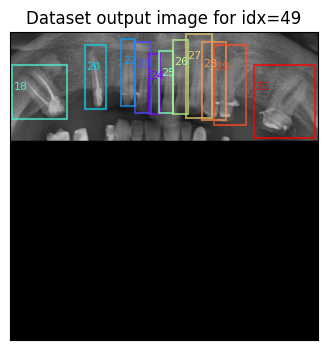

In [11]:
# Try the dataset class
dataset = DatasetFromDF(data=df,
                        image_processor=image_processor,
                        image_dir=xrays_dir,
                        file_name_col='file_name',
                        label_id_col='ada',
                        bbox_col='bbox',
                        transformations=transformations)

print(f'Total number of images: {dataset.__len__()}')
idx = file_name_idx
output = dataset[idx]

# Verify the output image for the dataset (see above)
output_image = np.transpose(output.get('pixel_values').numpy(), (1, 2, 0))
output_labels = output.get('labels')
output_labels_classes = list(output_labels.get('class_labels').numpy())
output_labels_size = list(output_labels.get('size').numpy())
output_width = int(output_labels_size[1])
output_height = int(output_labels_size[0])
output_boxes_yolo = output_labels.get('boxes')
# We need to convert the bounding boxes from yolo format into the coco format
output_boxes_xywh = [yolo2xywh(yolo_bbox=list(yolobox), 
                               image_width=output_width, 
                               image_height=output_height) for yolobox in output_boxes_yolo] 
# Let's also clip the new bounding boxes to the image boundaries
output_boxes_xywh = [clipxywh(box, xlim=[0, output_width], ylim=[0, output_height], decimals=0) for box in output_boxes_xywh]
# Plot the image with the bounding boxes
fig, ax = plt.subplots(figsize=(4, 4))
ax = plot_boxes(image=output_image, box_list=output_boxes_xywh, ax=ax, label_list=output_labels_classes)
ax.set(title=f'Dataset output image for idx={idx}')
plt.show()